## Introduction

We set out to answer a fun but subjective question:

### *What is the best neighborhood to live in during the summer in Pittsburgh?*

![Alt Text](https://images.squarespace-cdn.com/content/v1/57d6004f8419c258721e9426/1562682522416-277XW0O2HS8IJIA276Q6/The+Duquesne+Incline)


Since "best" is open to interpretation, very subjective, we decided to focus on **amenities that are especially valuable during the summer** — spaces for cooling off, gathering, and playing outdoors. 

### Our Metrics:
We used the following criteria to evaluate each neighborhood:

<img src="playground_image.jpg" width="600"/>

- **Where is the most playground equipment located?**  
  Playgrounds are essential for families with children and encourage outdoor play and community interaction.

<img src="shelter_image.jpg" width="600"/>

- **Where are the most shelters located?**  
  Shelters provide shaded and covered spaces for picnics, events, and rest, especially useful on hot or rainy days.

<img src="schenley_pool.jpg" width="600"/>

- **Which neighborhoods have public pools?**  
  Pools are a classic summer staple — perfect for cooling off, exercising, and socializing.

---
We retrieved the associated datasets from the WPRDC. These datasets offer a concrete way to assess which neighborhoods are rich in public amenities that enhance quality of life during Pittsburgh’s summer months!


Now let's get to coding!
First we need to run our imports:

In [5]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas

Below we begin data analysis by combining our metrics.
We read in each dataset.

One issue we had is that the original WPRDC shelters dataset had locations as parks and street names, but not neighborhoods. So the dataset we use here is not the one from WPRDC, but our own where we added a neighborhood column
to the shelters datasheet.

In [6]:
#NOTE: each of these datasets has a column called "neighborhood"
playground_equip = pd.read_csv("Playground_Equiptment.csv")  
pools = pd.read_csv("Pools.csv")
shel = pd.read_csv("shelters_with_neighborhood_locations.csv")

Below, we get value counts for each entity (playground equiptment, pool, or shelter) by neighborhood.

We used these pandas methods:
`.groupby()` sorts by neighborhood,
`.size()` counts how many rows there are,
`.rename()` gives the name of the resulting series.

In [7]:
pge_counts = (playground_equip
             .groupby("neighborhood")
             .size()
             .rename("play_count"))
#This groups playground equiptment entries by neighborhood and counts how many rows each neighborhood has
#meaning it counts how many playground equiptment there are in each neighborhood

print(f"Playground equipment count:\n{pge_counts} \n")


# 2b. pools
pool_counts = (pools
               .groupby("neighborhood")
               .size()
               .rename("pool_count"))

print(f"pool count:\n{pool_counts} \n")

# 2c. shelters 
shel_counts = (shel
               .groupby("neighborhood")
               .size()
               .rename("shelter_count"))
print(f"shelter count:\n{shel_counts} \n")

Playground equipment count:
neighborhood
Allegheny Center       15
Allentown               4
Banksville              6
Bedford Dwellings       3
Beechview              21
                       ..
Upper Lawrenceville     5
West End                3
West Oakland            1
Westwood                2
Windgap                 5
Name: play_count, Length: 68, dtype: int64 

pool count:
neighborhood
Allegheny Center            1
Banksville                  1
Bedford Dwellings           1
Beechview                   1
Beltzhoover                 1
Bloomfield                  1
Brighton Heights            1
Brookline                   1
Carrick                     1
East Hills                  1
Greenfield                  1
Hazelwood                   1
Highland Park               2
Homewood South              1
Lincoln Place               1
Lincoln-Lemington-Belmar    1
Mount Washington            1
Perry North                 1
Polish Hill                 1
Shadyside                   1
She

Now that we have our counts, how do we combine them?

The code below creates a list of **all** the neighborhoods that appear in any of our three datasets. 
The index of each of our series (`pge_counts`, `pool_counts`, `shel_counts`) is a neighborhood, since each of these are series containing neighborhoods and associated values.
It uses the `.index.union()`, which if you know anything about set theory is a union operation. This means every value will be included in the final result.
Therefore, after unioning these three datasets on their indexes, we now have a list of all the neighborhoods mentioned in any of our datasets!


With this list, we initialize a new dataframe to work with. This gives us the work room to do our final calculations.


In [8]:

all_neighborhoods = pge_counts.index.union(pool_counts.index).union(shel_counts.index)
df = pd.DataFrame(index=all_neighborhoods)

print(df)

Empty DataFrame
Columns: []
Index: [Allegheny Center, Allentown, Banksville, Bedford Dwellings, Beechview, Beltzhoover, Bloomfield, Bluff, Bon Air, Brighton Heights, Brookline, Carrick, Central Lawrenceville, Central Northside, Central Oakland, Crafton Heights, Crawford-Roberts, Duquesne Heights, East Allegheny, East Carnegie, East Hills, East Liberty, Elliott, Esplen, Fairywood, Fineview, Fox Chapel, Garfield, Greenfield, Hays, Hazelwood, Highland Park, Homewood North, Homewood South, Homewood West, Larimer, Lincoln Place, Lincoln-Lemington-Belmar, Lincoln–Lemington–Belmar, Lower Lawrenceville, Manchester, Marshall-Shadeland, Middle Hill, Morningside, Mount Washington, New Homestead, Oakland, Oakwood, Perry North, Perry South, Point Breeze, Point Breeze North, Polish Hill, Regent Square, Shadyside, Sheraden, South Oakland, South Side Flats, South Side Slopes, Spring Garden, Spring Hill-City View, Squirrel Hill, Squirrel Hill North, Squirrel Hill South, Stanton Heights, Strip District,

In the code below, we add our count values into the dataframe we just created.

For example, the first line of code creates a new column in our dataframe called "play_count".
It takes pge_counts (count of playground equiptment per neighborhood) and reindexes it to match the full list of neighborhoods (all_neighborhoods).


In [9]:
 # 4. Add the counts into the DataFrame
df["play_count"] = pge_counts.reindex(all_neighborhoods, fill_value=0)
df["pool_count"] = pool_counts.reindex(all_neighborhoods, fill_value=0)
df["shelter_count"] = shel_counts.reindex(all_neighborhoods, fill_value=0)

print(df["play_count"])

neighborhood
Allegheny Center       15
Allentown               4
Banksville              6
Bedford Dwellings       3
Beechview              21
                       ..
Upper Lawrenceville     5
West End                3
West Oakland            1
Westwood                2
Windgap                 5
Name: play_count, Length: 75, dtype: int64


To evaluate each neighborhood evenly, we decided to use a weighted point system.

A pool would be worth 10 points, a shelter 5 points, and a piece of playground equiptment 1 point.
These weights were chosen based on the level of infrastructure, cost, and community value associated with each resource:

- Pools are more expensive to build and maintain, and serve a wide population—hence the highest weight.

- Shelters offer protected space and are essential for group gatherings or emergency use, making them moderately weighted.

- Playground equipment is still valuable, especially for children’s recreation, but each item is relatively small in scale.

Below we created a dictionary defining these weights.

In our df DataFrame, we calculate a new column called score, which totals up the number of each amenity (pool, shelter, playground equiptment) in a neighborhood multiplied by its respective weight. This gives us a single number to compare neighborhoods more easily.
Our dataframe is printed out so you can see what this calculates to.

In [15]:

WEIGHTS = {
    "pool_count": 10,
    "shelter_count": 5,
    "play_count": 1
}
df["score"] = (
    df["pool_count"] * WEIGHTS["pool_count"] +
    df["shelter_count"] * WEIGHTS["shelter_count"] +
    df["play_count"] * WEIGHTS["play_count"]
)

print(df)

                     play_count  pool_count  shelter_count  score
neighborhood                                                     
Allegheny Center             15           1              0     25
Allentown                     4           0              0      4
Banksville                    6           1              0     16
Bedford Dwellings             3           1              0     13
Beechview                    21           1              0     31
...                         ...         ...            ...    ...
Upper Lawrenceville           5           0              0      5
West End                      3           0              0      3
West Oakland                  1           0              0      1
Westwood                      2           1              1     17
Windgap                       5           0              0      5

[75 rows x 4 columns]


Next, we determine our top neighborhoods based on our weighted point system!
and let's graph it!

To make our graph easy to read and understandable, we had to do some customization.

First we create a figure (fig) and axes (ax) object to plot on. figsize=(10, 5) sets the width and height of the plot in inches.
`top["score"].head(10).plot(kind="bar", ax=ax)` Plots a bar chart of the top 10 neighborhoods ranked by the score column. Top refers to the dataframe where we sorted our neighborhods by descending score order.

The rest of the code here is mostly self explanatory - giving our graph a title, labels, and making sure it's legible with label rotations.


                     play_count  pool_count  shelter_count  score
neighborhood                                                     
Highland Park                10           2             11     85
Squirrel Hill South          32           1              0     42
Beechview                    21           1              0     31
Sheraden                     13           1              1     28
East Liberty                 26           0              0     26
Perry North                   6           1              2     26
Beltzhoover                  10           1              1     25
Allegheny Center             15           1              0     25
South Side Flats              5           2              0     25
South Side Slopes            14           1              0     24


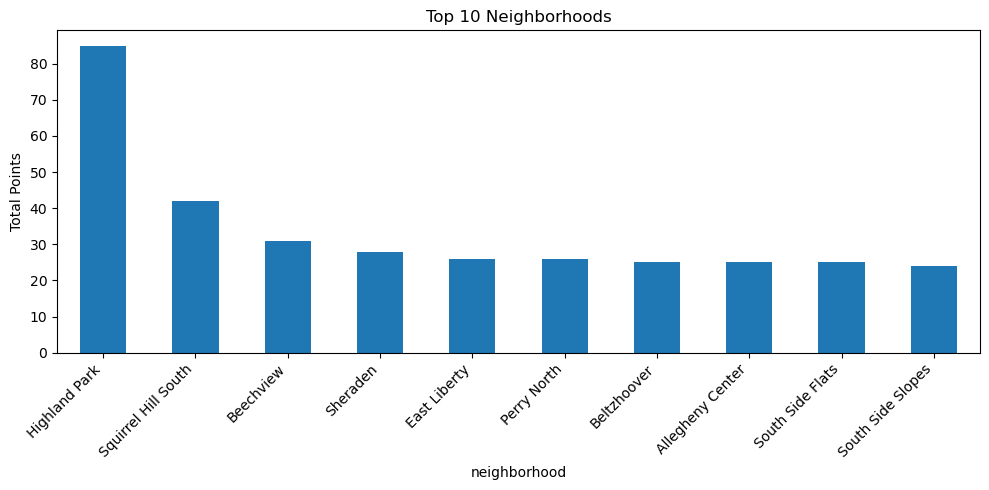

In [14]:
#sort and display top neighborhoods
top = df.sort_values("score", ascending=False)
print(top.head(10))


fig, ax = plt.subplots(figsize=(10, 5))
top["score"].head(10).plot(kind="bar", ax=ax)
ax.set_ylabel("Total Points")
ax.set_title("Top 10 Neighborhoods")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()#automatically adjusts spacing so nothing is cut off or overlaps
plt.show()


**Conclusion**

To identify the best neighborhood in Pittsburgh to live in in the summer, our team developed a point-based system. We assigned points based on the number of playgrounds (1 point each), shelters (5 points each), and pools (10 points each). This scoring method enabled us to fairly compare neighborhoods by weighing different types of amenities according to their significance and availability. In our project, Highland Park ranked as the top neighborhood for summer recreational amenities, with a total of 85 points. This is largely due to its high number of shelters (11), as well as presence of multiple pools (2) and playgrounds (10). This combination shows that Highland Park excels in multiple areas, offering diverse and plentiful recreational resources for the community, and it is an ideal place for families, group gatherings, and individual leisure activities, especially in the warm summer weather! This scoring method gave our team a fair, data-driven way to reconcile different findings and reach a shared conclusion to find the best neighborhood in Pittsburgh.


![Alt Text](https://dynamic-media-cdn.tripadvisor.com/media/photo-o/11/fa/99/7b/the-parks-conservancy.jpg?w=1200&h=1200&s=1)